In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("categorized_tweets.csv")
df.head()
df = df[df["Category"] != "damaged_infrastructure"] #comment out if ypu want to use damaged infrastructure set.

In [3]:
col = ["Category", "Tweet"]
df = df[col]
df.columns = ['Category', 'Tweet']
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head()

,Category,Tweet,category_id
0,fire,Firefighters battle a two-alarm blaze at 54 Ma...,0
1,fire,Pray for Fort McMurray \n#forrestfire #cl415 #...,0
2,fire,Addison and McGraw. E42X stretched. #fourthofj...,0
3,fire,With fire season starting my brother is a hots...,0
4,fire,These Forrest fires are OUT OF CONTROL! 🙏🏼🔥 #s...,0


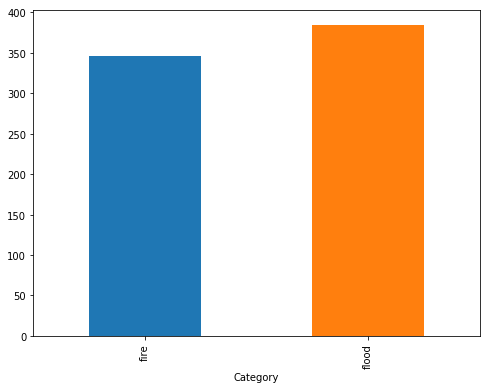

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Tweet.count().plot.bar(ylim=0)
plt.show()

Pretty even split of data. If using damaged infrastructure set, there's a huge class imbalance. 

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Tweet).toarray()
labels = df.category_id
features.shape

(730, 667)

In [13]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'fire':
  . Most correlated unigrams:
. floodwater
. forrestfire
  . Most correlated bigrams:
. hurricane sandy
. flood floodwater
# 'flood':
  . Most correlated unigrams:
. floodwater
. forrestfire
  . Most correlated bigrams:
. hurricane sandy
. flood floodwater


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LinearSVC().fit(X_train_tfidf, y_train)

In [17]:
#Type in a sentence where it says Text here to see what it classifies it to
print(clf.predict(count_vect.transform(['Text here'])))

['flood']


In [ ]:
#TODO: Create a neutral data set to add to model